In [1]:
PATH = './Dataset'
annotations_folder_path = PATH + '/annotations/'
images_folder_path = PATH +'/images/'
CHECKPOINT_PATH = './checkpoints'

In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
import time

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

## Imports for plotting
import matplotlib.pyplot as plt
# %matplotlib inline
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
# from matplotlib.colors import to_rgb
# import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2.0
# import seaborn as sns
# sns.reset_orig()
# sns.set()
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from torch.utils.data import Subset
from torch.utils.data import DataLoader, Dataset

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Seed set to 42


Device: cuda:0


In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    #transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class OxfordIIITPetDataset(Dataset):
    @staticmethod
    def extract_breed(name):
        return ' '.join(name.split("_")[:-1])

    def __init__(self, img_dir, transform=None, transform_label=None):
        self.img_dir = img_dir
        self.image_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]
        self.transform = transform
        self.transform_label = transform_label
        self.labels = list(set([self.extract_breed(name) for name in self.image_names]))
        self.transform_to_cat_dog = {idx: (0 if item[0].isupper() else 1) for idx, item in enumerate(self.labels)}
        self.labels_to_idx = {item: idx for idx, item in enumerate(self.labels)}
        self.values = {}

    def __len__(self):
        return len(self.image_names)
    
    def set_prediction(self, idx, value):
        self.values[idx] = value
    
    def unset_prediction(self, idx):
        if idx in self.values:
            del self.values[idx]

    def get_label(self, idx):
        image_name = self.image_names[idx]
        label = self.extract_breed(image_name)
        return label

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        real_label = self.extract_breed(image_name)
        real_label = self.labels_to_idx[real_label]
        label = real_label
        if idx in self.values:
            label = self.values[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label, idx, real_label
    
    def random_split_equal_distribution(self, split_ratios, only_indices=None):
        assert sum(split_ratios) == 1.0, "Split ratios must sum to 1"

        label_indices = {label: [] for label in self.labels}
        
        if only_indices is None:
            only_indices = range(len(self))

        # Group indices by label
        for idx in only_indices:
            label = self.get_label(idx)
            label_indices[label].append(idx)

        sub_indices = [[] for _ in range(len(split_ratios))]
        datasets = [None for _ in range(len(split_ratios))]

        # Shuffle indices within each label group and create subsets
        for label, indices in label_indices.items():
            np.random.shuffle(indices)
            num_samples = len(indices)
            start_idx = 0

            for i, ratio in enumerate(split_ratios):
                end_idx = start_idx + int(ratio * num_samples)
                sub_indices[i].extend(indices[start_idx:end_idx])
                start_idx = end_idx
            
        for i in range(len(split_ratios)):    
            datasets[i] = Subset(self, sub_indices[i])

        return datasets

In [4]:
pl.seed_everything(42)

dataset = OxfordIIITPetDataset(img_dir=images_folder_path, transform=transform)
train_set, val_set, test_set = dataset.random_split_equal_distribution([0.6, 0.2, 0.2])

train_dl = DataLoader(train_set, batch_size=50, shuffle=True, drop_last=True, num_workers=2)
val_dl = DataLoader(val_set, batch_size=50, shuffle=False, drop_last=True, num_workers=2)
test_dl = DataLoader(test_set, batch_size=50, shuffle=False, drop_last=False, num_workers=2)

def get_train_images(num):
    return torch.stack([train_set[i][0] for i in range(num)], dim=0)

Seed set to 42


In [5]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 256x256 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),  # 128x128 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 128x128 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),  # 64x64 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 4 * c_hid, kernel_size=3, padding=1, stride=2),  # 64x64 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),  # 32x32 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 8 * c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 8 * c_hid, kernel_size=3, padding=1),  # 16x16 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 16 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 16 * c_hid, kernel_size=3, padding=1),  # 8x8 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 32 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Conv2d(32 * c_hid, 32 * c_hid, kernel_size=3, padding=1),  # 4x4 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(4 * 4 * 32 * c_hid, latent_dim)  # Adjusted for 4x4 spatial dimensions
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int,
                 act_fn=nn.GELU):
        """
        Inputs:
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 32 * c_hid),  # Adjusted linear layer output size
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(32 * c_hid, 16 * c_hid, kernel_size=4, stride=2, padding=1),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(16 * c_hid, 16 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(16 * c_hid, 8 * c_hid, kernel_size=4, stride=2, padding=1),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(8 * c_hid, 8 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(8 * c_hid, 4 * c_hid, kernel_size=4, stride=2, padding=1),  # 16x16 => 32x32
            act_fn(),
            nn.Conv2d(4 * c_hid, 4 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(4 * c_hid, 2 * c_hid, kernel_size=4, stride=2, padding=1),  # 32x32 => 64x64
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=4, stride=2, padding=1),  # 64x64 => 128x128
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=4, stride=2, padding=1),  # 128x128 => 256x256

            nn.Tanh()  # The input images are scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x


class Autoencoder(pl.LightningModule):
    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 256,
                 height: int = 256):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x = batch[0] # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [6]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct images
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            # Plot and add to tensorboard
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2)
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [7]:
def train_oxford(latent_dim, load_file_path=None, epochs=100):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=epochs,
                         log_every_n_steps=10,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
    if load_file_path is not None:
        model.load_state_dict(torch.load(load_file_path))
    trainer.fit(model, train_dl, val_dl)
    # Test best model on validation and test set
    test_result = trainer.test(model, test_dl, verbose=False)
    result = {"test": test_result}
    return model, result

In [8]:
torch.cuda.empty_cache()
# Check if CUDA is available
if torch.cuda.is_available():
    # Get the available CUDA devices
    cuda_devices = torch.cuda.device_count()
    for i in range(cuda_devices):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
        print(f"  Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
else:
    print("CUDA is not available. You might want to run this code on a machine with CUDA support.")


Device 0: NVIDIA GeForce GTX 1650 with Max-Q Design
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


In [9]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [10]:
LATENT_DIM = 512

## Train

In [11]:
# Start training from scratch and save model
start_epoch = 0
epoch_jump = 100
model, result_2 = train_oxford(LATENT_DIM, epochs=epoch_jump)
torch.save(model.state_dict(), './models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch + epoch_jump))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 27.3 M | [2, 3, 256, 256] | [2, 512]        
1 | decoder | Decoder | 22.7 M | [2, 512]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
50.0 M    Trainable params
0         Non-trainable params
50.0 M    Total params
199.937   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 88/88 [00:57<00:00,  1.53it/s, v_num=8]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 88/88 [00:58<00:00,  1.51it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 88/88 [01:03<00:00,  1.38it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 88/88 [01:07<00:00,  1.31it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 88/88 [01:07<00:00,  1.30it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 88/88 [01:08<00:00,  1.29it/s, v_num=8]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 88/88 [01:08<00:00,

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 88/88 [01:23<00:00,  1.05it/s, v_num=8]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


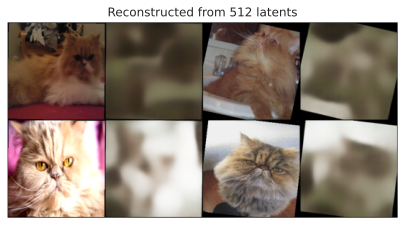

In [12]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)
time.sleep(600)

In [13]:
# Load previous model, continue training and save model
start_epoch = 100
epoch_jump = 100
model, result_2 = train_oxford(LATENT_DIM, load_file_path='./models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch), epochs=epoch_jump)
torch.save(model.state_dict(), './models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch + epoch_jump))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 27.3 M | [2, 3, 256, 256] | [2, 512]        
1 | decoder | Decoder | 22.7 M | [2, 512]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
50.0 M    Trainable params
0         Non-trainable params
50.0 M    Total params
199.937   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, v_num=9]          
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 88/88 [00:58<00:00,  1.52it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 88/88 [01:01<00:00,  1.43it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 88/88 [01:07<00:00,  1.30it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 88/88 [01:08<00:00,  1.28it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 88/88 [01:09<00:00,  1.26it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 88/88 [01:10<00:00,  1.25it/s, v_num=9]       
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 88/88 [01:10<00:00,

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 88/88 [01:24<00:00,  1.04it/s, v_num=9]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


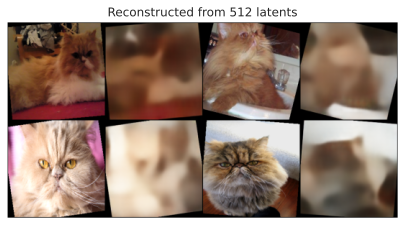

In [14]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)
time.sleep(600)

In [28]:
# Load previous model, continue training and save model
start_epoch = 210
epoch_jump = 50
model, result_2 = train_oxford(LATENT_DIM, load_file_path='./models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch), epochs=epoch_jump)
torch.save(model.state_dict(), './models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch + epoch_jump))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 27.3 M | [2, 3, 256, 256] | [2, 512]        
1 | decoder | Decoder | 22.7 M | [2, 512]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
50.0 M    Trainable params
0         Non-trainable params
50.0 M    Total params
199.937   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 88/88 [00:57<00:00,  1.53it/s, v_num=14]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 88/88 [01:04<00:00,  1.37it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 88/88 [01:09<00:00,  1.27it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 88/88 [01:11<00:00,  1.23it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 88/88 [01:13<00:00,  1.19it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 88/88 [01:11<00:00,  1.22it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 88/88 [01:12<00:00,  1.21it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 88/88 [01:14<00:00,  1.18it/s, v_num=14]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 88/88 [01:15<00:00,

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 88/88 [01:26<00:00,  1.02it/s, v_num=14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


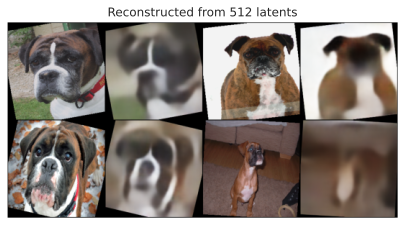

In [29]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)
# time.sleep(600)

In [17]:
# Load previous model, continue training and save model
start_epoch = 300
epoch_jump = 100
model, result_2 = train_oxford(LATENT_DIM, load_file_path='./models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch), epochs=epoch_jump)
torch.save(model.state_dict(), './models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch + epoch_jump))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 27.3 M | [2, 3, 256, 256] | [2, 512]        
1 | decoder | Decoder | 22.7 M | [2, 512]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
50.0 M    Trainable params
0         Non-trainable params
50.0 M    Total params
199.937   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 88/88 [00:55<00:00,  1.58it/s, v_num=11]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 88/88 [00:56<00:00,  1.55it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 88/88 [01:05<00:00,  1.35it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 88/88 [01:07<00:00,  1.31it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 88/88 [01:08<00:00,  1.29it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 88/88 [01:09<00:00,  1.27it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 88/88 [01:09<00:00,  1.26it/s, v_num=11]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 88/88 [01:11<00:00,

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 88/88 [01:25<00:00,  1.03it/s, v_num=11]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 30/30 [00:14<00:00,  2.11it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


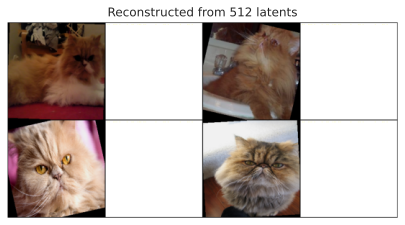

In [18]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)
time.sleep(600)

In [19]:
# Load previous model, continue training and save model
start_epoch = 400
epoch_jump = 100
model, result_2 = train_oxford(LATENT_DIM, load_file_path='./models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch), epochs=epoch_jump)
torch.save(model.state_dict(), './models/%s/autoencoder_%s.pth' % (LATENT_DIM, start_epoch + epoch_jump))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes         | Out sizes       
--------------------------------------------------------------------------
0 | encoder | Encoder | 27.3 M | [2, 3, 256, 256] | [2, 512]        
1 | decoder | Decoder | 22.7 M | [2, 512]         | [2, 3, 256, 256]
--------------------------------------------------------------------------
50.0 M    Trainable params
0         Non-trainable params
50.0 M    Total params
199.937   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 88/88 [00:55<00:00,  1.58it/s, v_num=12]         
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 88/88 [00:57<00:00,  1.54it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 88/88 [01:01<00:00,  1.42it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 88/88 [01:05<00:00,  1.34it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 88/88 [01:07<00:00,  1.31it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 88/88 [01:08<00:00,  1.29it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 88/88 [01:12<00:00,  1.22it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 88/88 [01:11<00:00,  1.24it/s, v_num=12]      
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 88/88 [01:10<00:00,

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 88/88 [01:29<00:00,  0.98it/s, v_num=12]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 30/30 [00:10<00:00,  2.99it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


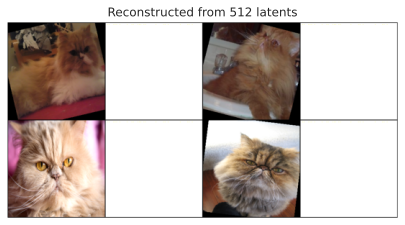

In [20]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)
time.sleep(600)

## Load

In [11]:
# Load prvious model
load_epoch = 500
model = Autoencoder(base_channel_size=32, latent_dim=LATENT_DIM)
model.load_state_dict(torch.load('./models/%s/autoencoder_%s.pth' % (LATENT_DIM, load_epoch)))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


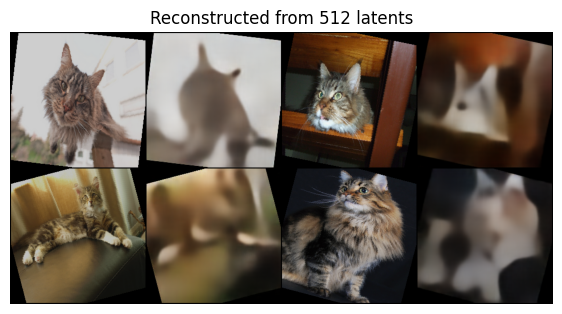

In [12]:
input_imgs = get_train_images(4)
visualize_reconstructions(model, input_imgs)

In [13]:
UNLABELLED = 0.5
unlabelled_dt, labelled_dt = dataset.random_split_equal_distribution([UNLABELLED, 1 - UNLABELLED], only_indices=train_dl.dataset.indices)
unlabelled_dl = DataLoader(unlabelled_dt, batch_size=50, shuffle=True, drop_last=True, num_workers=2)
labelled_dl = DataLoader(labelled_dt, batch_size=50, shuffle=True, drop_last=True, num_workers=2)

In [14]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    embed_list, label_list = [], []
    model.eval()
    for imgs, _, _, label in data_loader:
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        for i in range(len(label)):
            embed_list.append(z[i].numpy())
            label_list.append(label[i].item())
    return embed_list, label_list

unlabelled_emb, unlabelled_real_labels = embed_imgs(model, unlabelled_dl)
labelled_emb, labelled_real_labels = embed_imgs(model, labelled_dl)


In [16]:
unlabelled_real_labels_cat_dog = [dataset.transform_to_cat_dog[item] for item in unlabelled_real_labels]
labelled_real_labels_cat_dog = [dataset.transform_to_cat_dog[item] for item in labelled_real_labels]

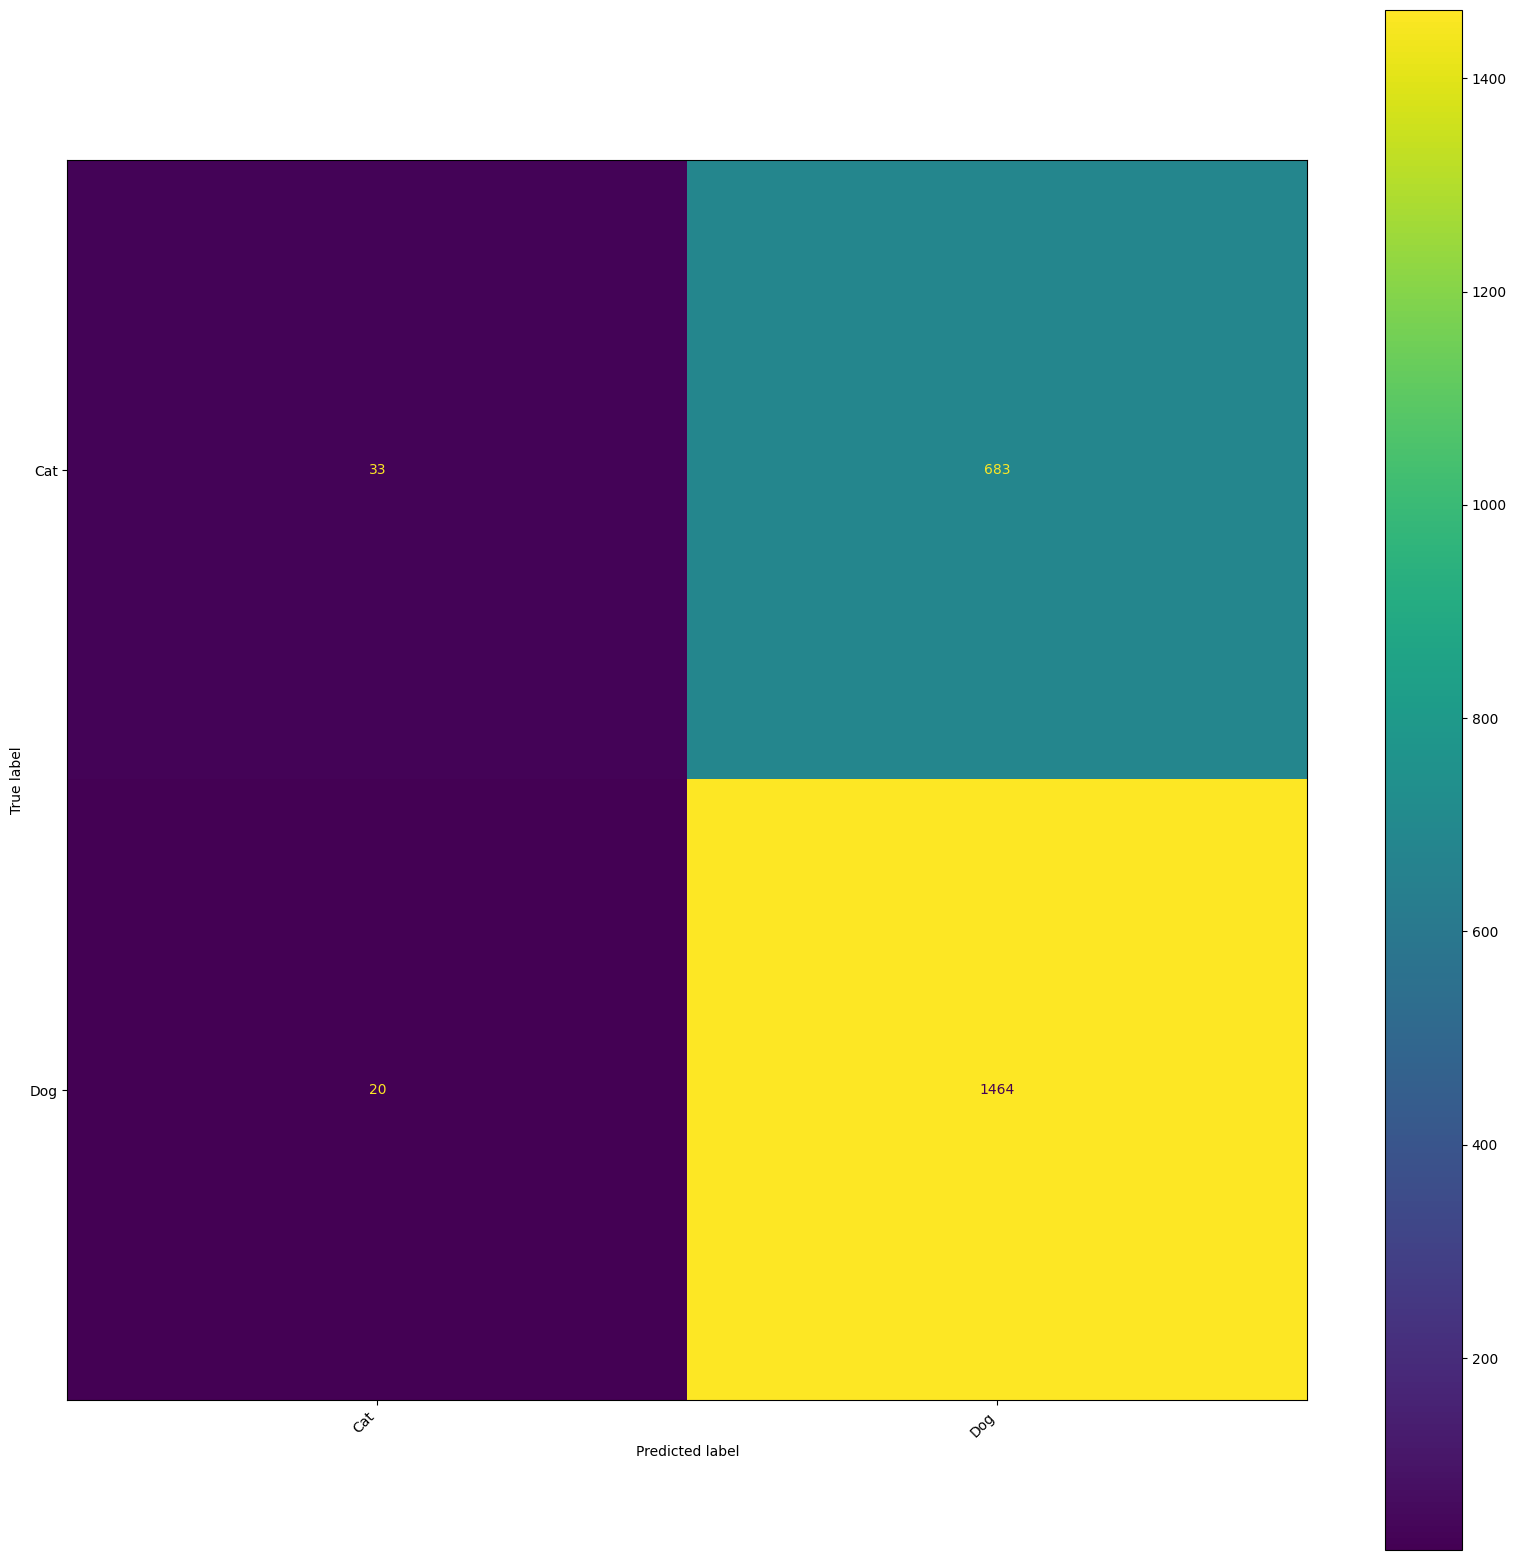

In [21]:
def knn_predict_labels(labelled_emb, labelled_labels, unlabelled_emb, k=10):
    # Create and train the KNN model
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(labelled_emb, labelled_labels)
    # Predict labels for unlabelled data
    predicted_labels = knn_model.predict(unlabelled_emb)
    return predicted_labels

def evaluate_model(unlabelled_real_labels, predicted_labels):
    # Create confusion matrix
    cm = confusion_matrix(unlabelled_real_labels, predicted_labels)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Cat', 'Dog'])
    fig, ax = plt.subplots(figsize=(20,20))
    cmd.plot(ax=ax)
    plt.xticks(rotation=45, ha='right')
    plt.show()

unlabelled_predicted_labels_cat_dog = knn_predict_labels(labelled_emb, labelled_real_labels_cat_dog, unlabelled_emb, k=42)
evaluate_model(unlabelled_real_labels_cat_dog, unlabelled_predicted_labels_cat_dog)

In [20]:
from sklearn.metrics import accuracy_score

def knn_predict_labels(labelled_emb, labelled_labels, unlabelled_emb, unlabelled_labels, max_k=200):
    best_accuracy = 0
    best_k = 0
    best_predicted_labels = None

    for k in range(1, max_k + 1):
        # Create and train the KNN model
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(labelled_emb, labelled_labels)

        # Predict labels for unlabelled data
        predicted_labels = knn_model.predict(unlabelled_emb)
        
        # Calculate accuracy
        accuracy = accuracy_score(unlabelled_labels, predicted_labels)

        # Check if current k gives better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
            best_predicted_labels = predicted_labels

    print("Best k:", best_k)
    print("Best accuracy:", best_accuracy)

    return best_predicted_labels

knn_predict_labels(labelled_emb, labelled_real_labels_cat_dog, unlabelled_emb, unlabelled_real_labels_cat_dog)

Best k: 42
Best accuracy: 0.6804545454545454


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8, type='euclidean'):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    if type == 'euclidean':
        dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    elif type == 'cosine':
        dist = F.cosine_similarity(query_z[None,:], key_embeds[1])
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    # Plot K closest images
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(train_img_embeds[0][i], train_img_embeds[1][i], key_embeds=train_img_embeds, type='cosine')